### Import Block

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.utils import class_weight
import skimage.measure

%matplotlib inline

### Function Definitions

In [2]:
# Loader functions
# Inspiration: https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a

def get_2d_input(path):
    # Load array.
    t_2d_input = np.load(path)
    
    #return t_2d_input
    return t_2d_input

def get_1d_input(path):
    # Load array.
    t_1d_input = np.load(path)
    
    # Expand dimensions to match model input.
    t_1d_input = tf.expand_dims(tf.expand_dims(t_1d_input, 2), 2)
    
    # Put channel dim at the end.
    t_1d_input = np.moveaxis(t_1d_input, 1, -1)
    
    return t_1d_input

def get_output(path):
    # Load array.
    t_output = np.load(path)
    
    # Put channel dim at the end.
    t_output = np.moveaxis(t_output, 0, -1)
    return t_output

def data_generator(samples, num_samples, batch_size = 64, calculated_sample_weights = None):
    
    while True:
        # Suffle data at the start of each epoch.
        sample_indicies = np.arange(num_samples)
        np.random.shuffle(sample_indicies)
        n = 0
        
        while n + batch_size < num_samples:
            # Get indicies for the batch
            batch_samples  = sample_indicies[n:n + batch_size]
            n += batch_size

            batch_input_2d  = []
            batch_input_1d  = []
            batch_output = [] 
            batch_sample_weights = []

            # Read in each input, perform preprocessing and get labels
            for sample in batch_samples:
                input_2d = get_2d_input(samples.iloc[sample].features_2d)
                input_1d = get_1d_input(samples.iloc[sample].features_1d)
                output = get_output(samples.iloc[sample].labels)
                
                batch_input_2d += [input_2d]
                batch_input_1d += [input_1d]
                batch_output += [output]

                if type(calculated_sample_weights) != type(None):
                    sample_weights = calculated_sample_weights[sample]
                    batch_sample_weights += [sample_weights]
                
            # Return a tuple to feed the network
            batch_x = np.array(batch_input_2d)
            batch_v = np.array(batch_input_1d)
            batch_y = np.minimum(np.array(batch_output),1)
            
            if type(calculated_sample_weights) == type(None):
                yield([batch_x[:,:,:,:,:1], tf.squeeze(batch_x[:,:1,:,:,1:2], axis = 1), batch_v], batch_y)
            else:
                batch_sample_weights = np.array(batch_sample_weights)
                yield([batch_x[:,:,:,:,:1], tf.squeeze(batch_x[:,:1,:,:,1:2], axis = 1), batch_v], batch_y, batch_sample_weights)

In [3]:
# Solution for problem with class_weights not working with 3D outputs in tensorflow.
# From: https://github.com/keras-team/keras/issues/3653
def generate_sample_weights(training_data, class_weights): 
    #replaces values for up to 3 classes with the values from class_weights#
    sample_weights = [np.where(y==0,class_weights[0],
                        np.where(y==1,class_weights[1],
                        y)) for y in training_data]
    return np.asarray(sample_weights)

In [4]:
# SSIM/PSNR loss functions.
# Inspiration: https://stackoverflow.com/questions/57357146/use-ssim-loss-function-with-keras
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def psnr_loss(y_true, y_pred):
    return 100 - tf.reduce_mean(tf.image.psnr(y_true, y_pred, 1.0))

In [5]:
# Dice loss functions.
# From: https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

### Model Assembly

In [6]:
fire_encoder = tf.keras.models.load_model('Models/MINST_Agg_01'
                                         , custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})
fire_encoder.summary()

Model: "fire_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fire_time_feature_1 (ConvLS  (None, 10, 32, 32, 128)  1651712   
 TM2D)                                                           
                                                                 
 fire_time_feature_2 (ConvLS  (None, 10, 32, 32, 64)   442624    
 TM2D)                                                           
                                                                 
 fire_to_2D (ConvLSTM2D)     (None, 32, 32, 64)        33024     
                                                                 
 output (Conv2D)             (None, 32, 32, 1)         65        
                                                                 
Total params: 2,127,425
Trainable params: 2,127,425
Non-trainable params: 0
_________________________________________________________________


In [7]:
defo_input = layers.Input(shape = ((32,32,1)), name = 'defo_input')
d = layers.Conv2D(128, (5,5), padding = 'same', name = 'defo_conv_A', activation = 'relu')(defo_input)
d = layers.Conv2D(64, (3,3), padding = 'same', name = 'defo_conv_B', activation = 'relu')(d)
d = layers.Conv2D(32, (1,1), padding = 'same', name = 'defo_conv_C', activation = 'relu')(d)

defo_encoder = tf.keras.Model(inputs = defo_input, outputs = d, name = 'defo_encoder')
defo_encoder.summary()

Model: "defo_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 defo_input (InputLayer)     [(None, 32, 32, 1)]       0         
                                                                 
 defo_conv_A (Conv2D)        (None, 32, 32, 128)       3328      
                                                                 
 defo_conv_B (Conv2D)        (None, 32, 32, 64)        73792     
                                                                 
 defo_conv_C (Conv2D)        (None, 32, 32, 32)        2080      
                                                                 
Total params: 79,200
Trainable params: 79,200
Non-trainable params: 0
_________________________________________________________________


In [8]:
precip_input = layers.Input(shape = ((10,1,1,192)), name = 'precip_input')
p = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(1, 1),
    padding='same',
    return_sequences=True,
    activation = 'relu',
    name = 'precip_time_features')(precip_input)
p = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(1, 1),
    padding='same',
    return_sequences=False,
    activation = 'relu',
    name = 'precip_to_FC')(p)
p = layers.Conv2DTranspose(32, (2,2), strides=(2,2), activation='relu', padding='same', name = 'precip_to_grid_2x2')(p)
p = layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same', name = 'precip_to_grid_4x4')(p)
p = layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same', name = 'precip_to_grid_8x8')(p)
p = layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same', name = 'precip_to_grid_16x16')(p)
p = layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same', name = 'precip_to_grid_32x32')(p)

precip_encoder = tf.keras.Model(inputs = precip_input, outputs = p, name = 'precip_encoder')
precip_encoder.summary()

Model: "precip_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 precip_input (InputLayer)   [(None, 10, 1, 1, 192)]   0         
                                                                 
 precip_time_features (ConvL  (None, 10, 1, 1, 128)    164352    
 STM2D)                                                          
                                                                 
 precip_to_FC (ConvLSTM2D)   (None, 1, 1, 32)          20608     
                                                                 
 precip_to_grid_2x2 (Conv2DT  (None, 2, 2, 32)         4128      
 ranspose)                                                       
                                                                 
 precip_to_grid_4x4 (Conv2DT  (None, 4, 4, 32)         9248      
 ranspose)                                                       
                                                    

In [9]:
fire_encoder_headless = tf.keras.Model(inputs=fire_encoder.input, outputs=fire_encoder.get_layer('fire_to_2D').output)
cat_layer = layers.Concatenate(axis = -1)
features_cat = cat_layer([fire_encoder_headless.output, defo_encoder.output, precip_encoder.output])
c = layers.Conv2D(64, (3,3), padding = 'same', name = 'combo_conv_A', activation = 'relu')(features_cat)
c = layers.Conv2D(64, (3,3), padding = 'same', name = 'combo_conv_B', activation = 'relu')(c)
combo_out = layers.Conv2D(1, (1,1), padding = 'same', name = 'combo_output', activation = 'relu')(c)

combo_model = tf.keras.Model(inputs = (fire_encoder.input, defo_encoder.input, precip_encoder.input),
                             outputs = combo_out)
combo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 precip_input (InputLayer)      [(None, 10, 1, 1, 1  0           []                               
                                92)]                                                              
                                                                                                  
 precip_time_features (ConvLSTM  (None, 10, 1, 1, 12  164352     ['precip_input[0][0]']           
 2D)                            8)                                                                
                                                                                                  
 precip_to_FC (ConvLSTM2D)      (None, 1, 1, 32)     20608       ['precip_time_features[0][0]']   
                                                                                            

In [13]:
# Compile model.
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
#loss_fn = tf.keras.losses.MeanSquaredError()
#loss_fn = ssim_loss()
#loss_fn = dice_coef_loss
combo_model.compile(loss=loss_fn, 
                    optimizer=opt, 
                    metrics=[tf.keras.metrics.MeanSquaredError(name='MSE'),
                             tf.keras.metrics.AUC(name='AUC'),
                             ssim_loss,
                             psnr_loss
                            ])

In [14]:
# Test on dummy data to see that shapes look right.
fire_batch = tf.zeros([8,10,32,32,1], dtype = 'float32')
defo_batch = tf.zeros([8,32,32,1], dtype = 'float32')
precip_batch = tf.zeros([8,10,1,1,192], dtype = 'float32')
combo_model.predict((fire_batch, defo_batch, precip_batch)).shape

1/1 [==============================] - 1s 974ms/step


(8, 32, 32, 1)

### Train model on combined dataset.

In [12]:
# Freeze layers of the motion encoder to start, because it's already pretrained on MNIST.
combo_model.layers[4].trainable = False
combo_model.layers[7].trainable = False
combo_model.layers[10].trainable = False
combo_model.layers[13].trainable = False

# Confirm that the right layers are frozen.
for t_layer in combo_model.layers:
    print(t_layer.name, t_layer.trainable)

precip_input True
precip_time_features True
precip_to_FC True
precip_to_grid_2x2 True
fire_input False
defo_input True
precip_to_grid_4x4 True
fire_time_feature_1 False
defo_conv_A True
precip_to_grid_8x8 True
fire_time_feature_2 False
defo_conv_B True
precip_to_grid_16x16 True
fire_to_2D False
defo_conv_C True
precip_to_grid_32x32 True
concatenate True
combo_conv_A True
combo_conv_B True
combo_output True


In [15]:
# Load metadata on yearly datasets.
df_2017 = pd.read_csv('4fold_super/2017/meta.csv')
df_2018 = pd.read_csv('4fold_super/2018/meta.csv')
df_2019 = pd.read_csv('4fold_super/2019/meta.csv')
df_2020 = pd.read_csv('4fold_super/2020/meta.csv')

# Combine into desired train/val split.
meta_t = pd.concat([df_2017, df_2018, df_2019]).reset_index()
meta_v = df_2020

# Get all labels for use in calculating weights.
y_train = []
for x in range(0,len(meta_t)):
    y_train.append(np.load(meta_t.iloc[x].labels))
y_train = np.stack(y_train)
y_train = np.minimum(y_train,1)
y_train = np.moveaxis(y_train, 1, -1)

# Get weights.
weights = class_weight.compute_class_weight('balanced',
                                            [0,1],
                                            y_train.flatten())
calculated_sample_weights = generate_sample_weights(y_train, weights)

# Get generators.
batch_size = 32
t_gen = data_generator(meta_t, len(meta_t), batch_size = batch_size, calculated_sample_weights = calculated_sample_weights)
v_gen = data_generator(meta_v, len(meta_v), batch_size = batch_size)

C:\Users\covad\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0, 1], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [16]:
# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

# Train model.
combo_model.fit(t_gen, 
                   epochs = 20, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = v_gen,
                   callbacks = [early_stopping, reduce_lr],
                   steps_per_epoch = len(meta_t) // batch_size,
                   validation_steps = len(meta_v) // batch_size
                  )

Epoch 1/20
468/468 [==============================] - 343s 717ms/step - loss: 0.4714 - MSE: 0.1234 - AUC: 0.8672 - ssim_loss: 0.9942 - psnr_loss: 90.2123 - val_loss: 0.4093 - val_MSE: 0.1199 - val_AUC: 0.8991 - val_ssim_loss: 0.9925 - val_psnr_loss: 90.0801 - lr: 1.0000e-04
Epoch 2/20
468/468 [==============================] - 334s 714ms/step - loss: 0.4232 - MSE: 0.1172 - AUC: 0.8856 - ssim_loss: 0.9932 - psnr_loss: 89.9306 - val_loss: 0.4459 - val_MSE: 0.1278 - val_AUC: 0.9057 - val_ssim_loss: 0.9919 - val_psnr_loss: 90.3248 - lr: 1.0000e-04
Epoch 3/20
468/468 [==============================] - 333s 713ms/step - loss: 0.4174 - MSE: 0.1187 - AUC: 0.8890 - ssim_loss: 0.9926 - psnr_loss: 89.9187 - val_loss: 0.3705 - val_MSE: 0.1141 - val_AUC: 0.9008 - val_ssim_loss: 0.9927 - val_psnr_loss: 89.8322 - lr: 1.0000e-04
Epoch 4/20
468/468 [==============================] - 334s 713ms/step - loss: 0.4246 - MSE: 0.1234 - AUC: 0.8858 - ssim_loss: 0.9930 - psnr_loss: 90.0464 - val_loss: 0.5240 - 

In [19]:
# Unfreeze, switch to dice loss, then recompile.
for t_layer in combo_model.layers:
    t_layer.trainable = True
    
# Compile model.
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_fn = dice_coef_loss
combo_model.compile(loss=loss_fn, 
                    optimizer=opt, 
                    metrics=[tf.keras.metrics.MeanSquaredError(name='MSE'),
                             tf.keras.metrics.AUC(name='AUC'),
                             ssim_loss,
                             psnr_loss
                            ])

In [20]:
# Get generators.
batch_size = 32
t_gen = data_generator(meta_t, len(meta_t), batch_size = batch_size)
v_gen = data_generator(meta_v, len(meta_v), batch_size = batch_size)

In [21]:
# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

# Train model.
combo_model.fit(t_gen, 
                   epochs = 40, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = v_gen,
                   callbacks = [early_stopping, reduce_lr],
                   steps_per_epoch = len(meta_t) // batch_size,
                   validation_steps = len(meta_v) // batch_size
                  )

Epoch 1/40
468/468 [==============================] - 271s 563ms/step - loss: 0.6722 - MSE: 0.0247 - AUC: 0.6701 - ssim_loss: 0.2775 - psnr_loss: -inf - val_loss: 0.5623 - val_MSE: 0.0566 - val_AUC: 0.6633 - val_ssim_loss: 0.2725 - val_psnr_loss: -inf - lr: 1.0000e-05
Epoch 2/40
468/468 [==============================] - 262s 560ms/step - loss: 0.5763 - MSE: 0.0812 - AUC: 0.6112 - ssim_loss: 0.2357 - psnr_loss: -inf - val_loss: 0.4715 - val_MSE: 0.2155 - val_AUC: 0.6331 - val_ssim_loss: 0.2726 - val_psnr_loss: -inf - lr: 1.0000e-05
Epoch 3/40
468/468 [==============================] - 266s 568ms/step - loss: 0.5208 - MSE: 0.2090 - AUC: 0.5931 - ssim_loss: 0.2337 - psnr_loss: -inf - val_loss: 0.4158 - val_MSE: 0.5646 - val_AUC: 0.6218 - val_ssim_loss: 0.2751 - val_psnr_loss: -inf - lr: 1.0000e-05
Epoch 4/40
468/468 [==============================] - 269s 576ms/step - loss: 0.4827 - MSE: 0.4244 - AUC: 0.5814 - ssim_loss: 0.2325 - psnr_loss: -inf - val_loss: 0.3739 - val_MSE: 1.0111 - val

KeyboardInterrupt: 

### Testing Fire Encoder on VIIRS Fire Data

In [12]:
# Load metadata on yearly datasets.
df_2017 = pd.read_csv('4fold_super/2017/meta.csv')
df_2018 = pd.read_csv('4fold_super/2018/meta.csv')
df_2019 = pd.read_csv('4fold_super/2019/meta.csv')
df_2020 = pd.read_csv('4fold_super/2020/meta.csv')

# Combine into desired train/val split.
meta_t = pd.concat([df_2017,df_2018,df_2019]).reset_index()
meta_v = df_2020

In [18]:
x_train, d_train, v_train, y_train, x_val, d_val, v_val, y_val = [],[],[],[],[],[],[],[]
for x in range(0,len(meta_t)):
    x_train.append(np.load(meta_t.iloc[x].features_2d)[:,:,:,:1])
    d_train.append(np.load(meta_t.iloc[x].features_2d)[:,0,:,1:2])
    v_train.append(np.load(meta_t.iloc[x].features_1d))
    y_train.append(np.load(meta_t.iloc[x].labels))

for x in range(0,len(meta_v)):
    x_val.append(np.load(meta_v.iloc[x].features_2d)[:,:,:,:1])
    d_val.append(np.load(meta_v.iloc[x].features_2d)[:,0,:,1:2])
    v_val.append(np.load(meta_v.iloc[x].features_1d))
    y_val.append(np.load(meta_v.iloc[x].labels))
    
    
x_train = np.stack(x_train)
d_train = np.stack(d_train)
v_train = np.stack(v_train)
y_train = np.stack(y_train)   
x_val = np.stack(x_val)
d_val = np.stack(d_val)
v_val = np.stack(v_val)
y_val = np.stack(y_val)

x_train = np.minimum(x_train,1)
d_train = np.minimum(d_train,1)
y_train = np.minimum(y_train,1)
y_train = np.moveaxis(y_train, 1, -1)

x_val = np.minimum(x_val,1)
d_val = np.minimum(x_val,1)
y_val = np.minimum(y_val,1)
y_val = np.moveaxis(y_val, 1, -1)

In [26]:
#Reload model from Phase 1.
#combo_model = tf.keras.models.load_model('Models/MINST_Agg_01', custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})

In [19]:
t_preds = combo_model.predict([x_val, d_val[:,0], np.expand_dims(v_val, [2,3])])

157/157 [==============================] - 41s 260ms/step


Sample Prediction Metrics:
SSIM: 0.011483428999781609 
PSNR: 0.12909388542175293 
MSE: 0.051175386 
Min Px: 0.0 
Max Px: 0.80625504 
Mean Px: 0.16635099 
Sample ID: 291


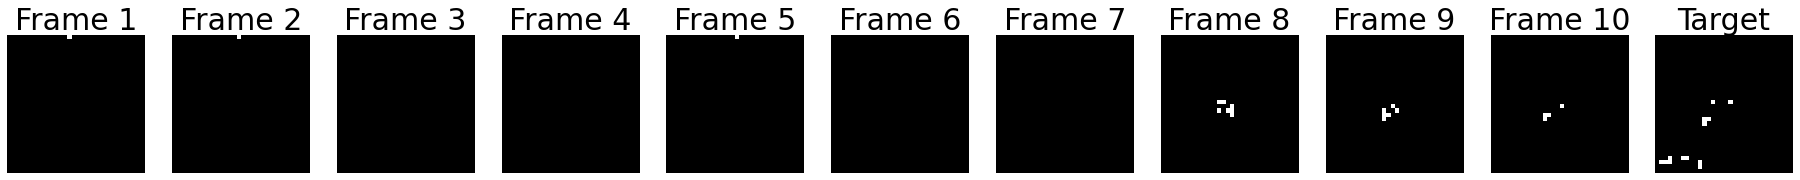

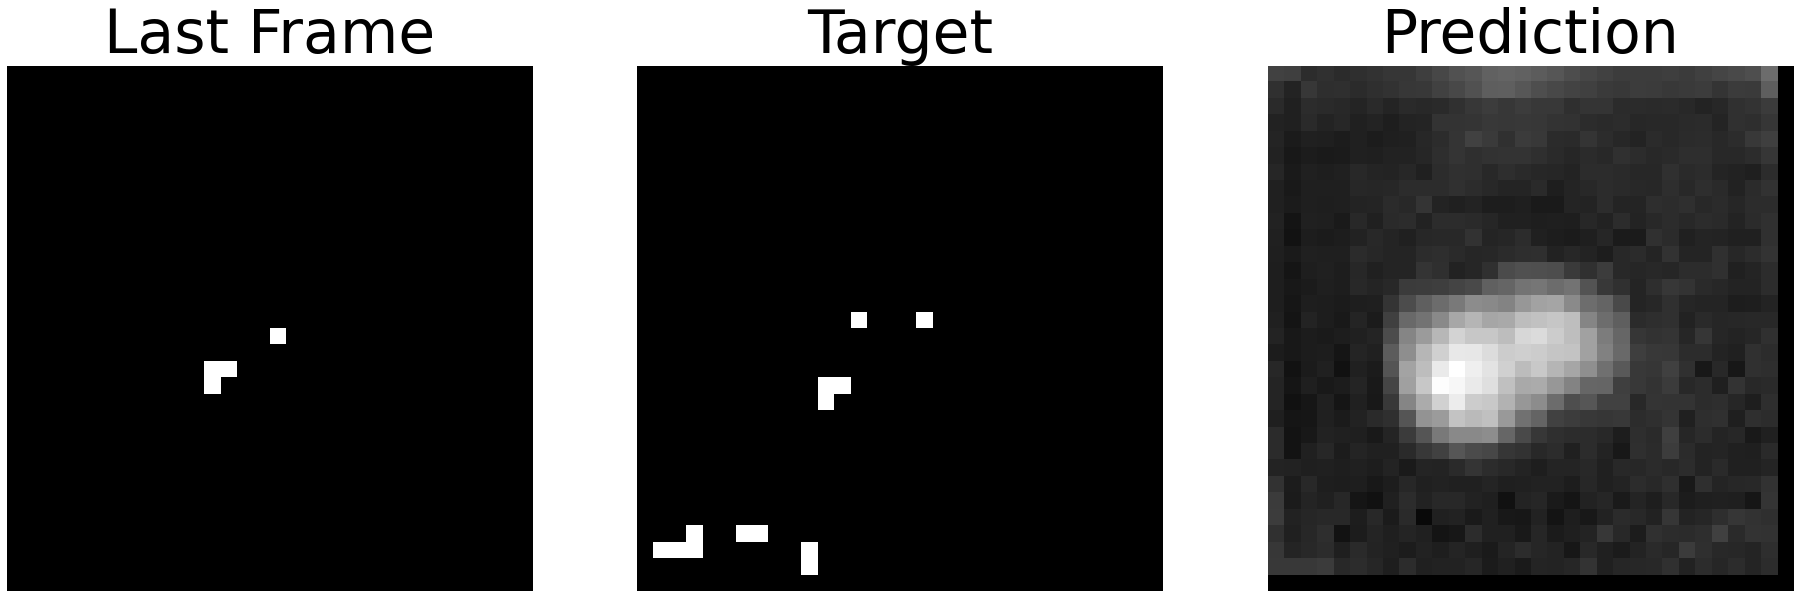

In [70]:
sample_idx = np.random.randint(0, len(x_val))

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(1, 11, figsize=(32, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes):
    if idx == 10:
        ax.imshow(np.squeeze(y_val[sample_idx]), cmap="gray")
        ax.set_title('Target')
        ax.title.set_fontsize(30)
        ax.axis("off")
    else:
        ax.imshow(np.squeeze(x_val[sample_idx][idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.title.set_fontsize(30)
        ax.axis("off")

fig, axes = plt.subplots(1, 3, figsize=(32, 16))
axes[0].imshow(np.squeeze(x_val[sample_idx][9]), cmap="gray")
axes[0].set_title('Last Frame')
axes[0].axis("off")
axes[0].title.set_fontsize(60)
axes[1].imshow(np.squeeze(y_val[sample_idx]), cmap="gray")
axes[1].set_title('Target')
axes[1].axis("off")
axes[1].title.set_fontsize(60)
axes[2].imshow(np.squeeze(t_preds[sample_idx]), cmap="gray")
axes[2].set_title('Prediction')
axes[2].axis("off")
axes[2].title.set_fontsize(60)

t_preds[sample_idx].min(), t_preds[sample_idx].max(), t_preds[sample_idx].mean(),
print('Sample Prediction Metrics:'
      '\nSSIM:', float(tf.image.ssim(tf.cast(y_val[sample_idx], dtype='float32'), t_preds[sample_idx], 1.0)),
      '\nPSNR:', float(tf.image.psnr(tf.cast(y_val[sample_idx], dtype='float32'), t_preds[sample_idx], 1.0) / 100),
      '\nMSE:', np.mean(tf.keras.metrics.mean_squared_error(y_val[sample_idx], t_preds[sample_idx])),
      '\nMin Px:', t_preds[sample_idx].min(),
      '\nMax Px:', t_preds[sample_idx].max(),
      '\nMean Px:', t_preds[sample_idx].mean(),
      '\nSample ID:', int(sample_idx)
     )

In [21]:
# Compute and show set scores.
set_ssim = tf.image.ssim(tf.cast(y_val, dtype='float32'), t_preds, 1.0)
set_psnr = tf.image.psnr(tf.cast(y_val, dtype='float32'), t_preds, 1.0)
set_mse = tf.keras.metrics.mean_squared_error(y_val, t_preds)
print('Model Prediction Report')
print('SSIM:', np.mean(set_ssim))
print('PSNR:', np.mean(set_psnr) / 100)
print('MSE:', np.mean(set_mse))

Model Prediction Report
SSIM: 0.008481416
PSNR: 0.10930078506469726
MSE: 0.098883234


In [71]:
combo_model.save('Models/Combo_Blur')

INFO:tensorflow:Assets written to: Models/Combo_Blur\assets


INFO:tensorflow:Assets written to: Models/Combo_Blur\assets
